# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [44]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key
if weather_api_key == "YOUR KEY HERE!":
    import sys
    sys.path.append(r"C:\Users\nlund\Documents\GitHub\untracked_files")
    from api_keys_NRL import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

In [25]:
# Define function for calculating linear regressions
def regress_line(x,y):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x,y)
    y_regress = x * slope + intercept
    line_text = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    print(f"The r-value is: {rvalue ** 2}")
    return y_regress, line_text

## Determine user's preferred data source

In [3]:
# Determine if user would like to load pre-populated weather data or
get_current_wx = input("Would you like to analyze current weather conditions (Y/N)?")

# If no, load provided data
if get_current_wx == "N":
    print("The user opted to load pre-populated weather data")
    input_file = "input_data\cities.csv"
    df_wx_data = pd.read_csv(input_file)
elif get_current_wx == "Y":
    print("The user opted to analyze current weather conditions")
else:
    print("The user chose an invalid option.")
    raise SystemExit("Stop executing notebook") 

The user opted to load pre-populated weather data


## Generate Cities List

In [22]:
if get_current_wx == "Y":
    # List for holding lat_lngs and cities
    lat_lngs = []
    cities = []

    # Create a set of random lat and lng combinations
    lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
    lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
    lat_lngs = zip(lats, lngs)

    # Identify nearest city for each lat, lng combination
    for lat_lng in lat_lngs:
        city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
        
        # If the city is unique, then add it to a our cities list
        if city not in cities:
            cities.append(city)

    # Print the city count to confirm sufficient count
    print(len(cities))
else:
    print(len(df_wx_data))

548


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [5]:
if get_current_wx == "Y":
    # Setup and call weather API

    # Save config information.
    url = "http://api.openweathermap.org/data/2.5/weather?"
    units = "imperial"

    # Build partial query URL
    query_url = f"{url}appid={weather_api_key}&units={units}&q="

    # set up lists to hold reponse info
    city_list = []
    lat_list = []
    lon_list = []
    max_temp_list = []
    humidity_list = []
    cloudiness_list = []
    wndspd_list = []
    country_list = []
    date_list = []
    call_counter = 1
    call_set = 1

    # Collect weather data using json api calls
    print('Beginning Data Retrieval')     
    print('-----------------------------')

    # Loop through the list of cities and perform a request for data on each and populate data lists
    for city in cities:
        response = requests.get(query_url + city).json()
        #print(json.dumps(response, indent=4, sort_keys=True))

        try:
            city_list.append(response['name'])
            lat_list.append(response['coord']['lon'])
            lon_list.append(response['coord']['lon'])
            max_temp_list.append(response['main']['temp_max'])
            humidity_list.append(response['main']['humidity'])
            cloudiness_list.append(response['clouds']['all'])
            wndspd_list.append(response['wind']['speed'])
            country_list.append(response['sys']['country'])
            date_list.append(response['dt'])

            print(f'Processing Record {call_counter} of Set {call_set} | {city}')

        except KeyError:
            print("City not found. Skipping...")

        if call_counter > 49:
            call_counter = 1
            call_set += 1
            time.sleep(10)    
        else:
            call_counter += 1

    print('-----------------------------')
    print('Data Retrieval Complete')      
    print('-----------------------------')

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [6]:
if get_current_wx == "Y":
    df_wx_data = pd.DataFrame({
        "City": city_list,
        "Lat": lat_list,
        "Lng": lon_list,
        "Max Temp": max_temp_list,
        "Humidity": humidity_list,
        "Cloudiness": cloudiness_list,
        "Wind Speed": wndspd_list,
        "Country": country_list,
        "Date": date_list})
else:
    df_wx_data = df_wx_data.loc[:,["City","Lat","Lng","Max Temp","Humidity","Cloudiness","Wind Speed","Country","Date"]]
df_wx_data.to_csv(output_data_file)
df_wx_data

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,ostrovnoy,68.05,39.51,37.50,72,2,7.16,RU,1558378754
1,mahebourg,-20.41,57.70,78.80,74,75,11.41,MU,1558378503
2,qaanaaq,77.48,-69.36,22.20,73,25,2.37,GL,1558378755
3,zhuhai,40.71,112.04,44.60,39,0,4.47,CN,1558378755
4,cape town,-33.93,18.42,55.99,76,20,8.05,ZA,1558378755
...,...,...,...,...,...,...,...,...,...
543,yabrud,33.97,36.66,80.60,32,0,8.05,SY,1558378840
544,paraiso,24.01,-104.61,84.20,4,5,16.11,MX,1558378898
545,veraval,49.65,0.71,61.00,62,0,8.05,FR,1558378898
546,novyy urgal,51.07,132.56,49.74,93,100,2.68,RU,1558378899


### Display summary statistics on the weather DataFrame

In [7]:
df_wx_data.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,5.480000e+02
mean,19.665146,20.675529,64.970785,67.671533,49.405109,8.672682,1.558379e+09
std,33.623560,90.307948,18.704318,23.697626,36.914201,5.865974,7.820486e+01
min,-54.810000,-173.230000,4.920000,4.000000,0.000000,0.540000,1.558378e+09
25%,-6.267500,-61.015000,53.970000,52.000000,13.750000,4.680000,1.558379e+09
50%,21.390000,21.240000,64.990000,71.000000,46.500000,7.010000,1.558379e+09
75%,47.887500,102.937500,80.600000,86.000000,81.000000,11.410000,1.558379e+09
max,78.220000,179.320000,104.100000,290.000000,100.000000,46.080000,1.558379e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [8]:
#  Check for cities that have humidity over 100%.
df_invalid_humidity = df_wx_data.loc[df_wx_data["Humidity"] > 100, ["City","Lat","Lng","Max Temp","Humidity","Cloudiness","Wind Speed","Country","Date"]]
df_invalid_humidity

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
129,paita,-5.09,-81.11,62.6,290,0,17.22,PE,1558378778


In [9]:
# Remove invalid humidity data
df_wx_data_clean = df_wx_data.loc[df_wx_data["Humidity"] <= 100, ["City","Lat","Lng","Max Temp","Humidity","Cloudiness","Wind Speed","Country","Date"]]
df_wx_data_clean.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,5.470000e+02
mean,19.710402,20.861609,64.975119,67.265082,49.495430,8.657057,1.558379e+09
std,33.637627,90.285396,18.721163,21.723477,36.887333,5.859917,7.826709e+01
min,-54.810000,-173.230000,4.920000,4.000000,0.000000,0.540000,1.558378e+09
25%,-6.315000,-60.820000,53.940000,52.000000,14.000000,4.680000,1.558379e+09
50%,21.430000,21.550000,64.990000,71.000000,47.000000,7.000000,1.558379e+09
75%,47.895000,103.165000,80.600000,86.000000,81.000000,11.410000,1.558379e+09
max,78.220000,179.320000,104.100000,100.000000,100.000000,46.080000,1.558379e+09


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [10]:
# Extract data collection date
pretty_date = []
for idx, row in df_wx_data_clean.iterrows():
    data_time = time.localtime(row["Date"])
    pretty_date.append(f"{data_time.tm_mon}/{data_time.tm_mday}/{data_time.tm_year}")

collection_date = str(set(pretty_date)).strip("{'}")
print(f"Data collected on {collection_date}")

Data collected on 5/20/2019


## Latitude vs. Temperature Plot

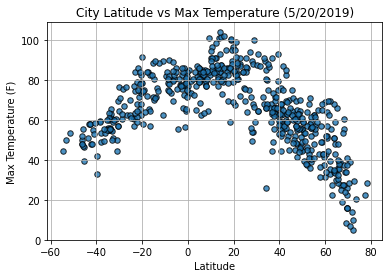

In [11]:
df_wx_data_clean.plot(
    "Lat","Max Temp",
    title=f"City Latitude vs Max Temperature ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.savefig("output_data/lat_temp.png",facecolor='w')
plt.show()

Nicole Lund: The Latitude vs Max temperature plot shows the latitude for each city vs the maximum temperature seen that day.

## Latitude vs. Humidity Plot

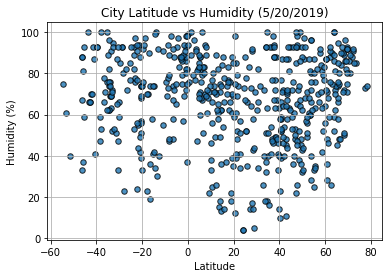

In [12]:
df_wx_data_clean.plot(
    "Lat","Humidity",
    title=f"City Latitude vs Humidity ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.savefig("output_data/lat_humidity.png",facecolor='w')
plt.show()

Nicole Lund: The Latitude vs Humidity plot shows the latitude for each city vs the current humidity.

## Latitude vs. Cloudiness Plot

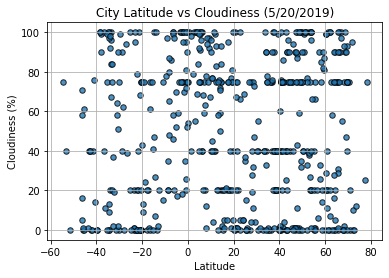

In [13]:
df_wx_data_clean.plot(
    "Lat","Cloudiness",
    title=f"City Latitude vs Cloudiness ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.savefig("output_data/lat_cloudiness.png",facecolor='w')
plt.show()

Nicole Lund: The Latitude vs Cloudiness plot shows the latitude for each city vs the percentage of the sky currently covered by clouds.

## Latitude vs. Wind Speed Plot

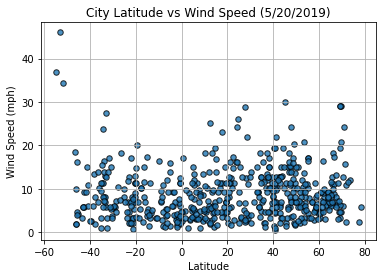

In [14]:
df_wx_data_clean.plot(
    "Lat","Wind Speed",
    title=f"City Latitude vs Wind Speed ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.savefig("output_data/lat_wndspd.png",facecolor='w')
plt.show()

Nicole Lund: The Latitude vs Wind Speed plot shows the latitude for each city vs the current wind speed.

## Linear Regression

Create separate figures for each hemisphere
* Northern hemisphere
* Southern hemisphere

In [23]:
# Collect data by northern and southern hemispheres
df_wx_data_clean_N_hemi = df_wx_data_clean.loc[df_wx_data_clean["Lat"]>=0]
df_wx_data_clean_S_hemi = df_wx_data_clean.loc[df_wx_data_clean["Lat"]<0]
df_wx_data_clean_S_hemi

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
1,mahebourg,-20.41,57.70,78.80,74,75,11.41,MU,1558378503
4,cape town,-33.93,18.42,55.99,76,20,8.05,ZA,1558378755
5,atuona,-9.80,-139.03,81.96,76,78,16.49,PF,1558378755
6,flinders,-34.58,150.85,60.01,62,0,11.41,AU,1558378755
7,opuwo,-18.06,13.84,72.06,23,0,5.44,NaN,1558378523
...,...,...,...,...,...,...,...,...,...
526,viedma,-40.81,-62.99,58.56,41,14,10.98,AR,1558378894
531,russell,-33.01,-68.80,50.00,71,75,12.75,AR,1558378895
536,padang,-0.92,100.36,81.24,82,100,7.65,ID,1558378896
539,palu,-0.90,119.87,78.72,80,72,3.83,ID,1558378897


### Latitude vs. Temperature Plots with linear regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.6644951847801387


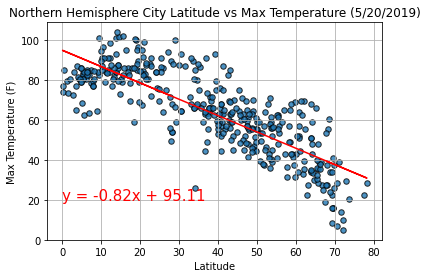

In [27]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_N_hemi["Lat"],df_wx_data_clean_N_hemi["Max Temp"])

# Plot the data
df_wx_data_clean_N_hemi.plot(
    "Lat","Max Temp",
    title=f"Northern Hemisphere City Latitude vs Max Temperature ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_N_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(0,20),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

plt.savefig("output_data/north_lat_temp.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Max Temperature as Latitude increases from the Equator. There is a negative slope in the linear regression that indicates it gets colder the further north one travels.  The r-value indicates that the regression model  describes the observed data moderately well.

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.5880057276369806


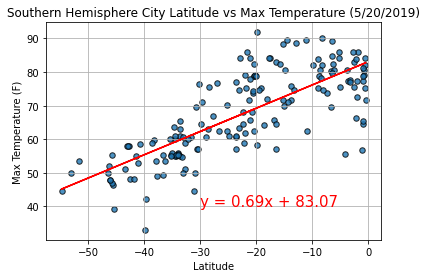

In [29]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_S_hemi["Lat"],df_wx_data_clean_S_hemi["Max Temp"])

# Plot the data
df_wx_data_clean_S_hemi.plot(
    "Lat","Max Temp",
    title=f"Southern Hemisphere City Latitude vs Max Temperature ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_S_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(-30,40),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

plt.savefig("output_data/south_lat_temp.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Max Temperature as Latitude increases from the South Pole. There is a positive slope in the linear regression that indicates it gets warmer the further north one travels.  The r-value indicates that the regression model describes the observed data moderately well.

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.010729512501511098


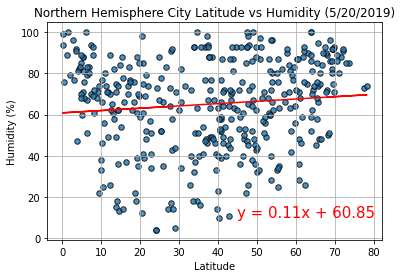

In [32]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_N_hemi["Lat"],df_wx_data_clean_N_hemi["Humidity"])

# Plot the data
df_wx_data_clean_N_hemi.plot(
    "Lat","Humidity",
    title=f"Northern Hemisphere City Latitude vs Humidity ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_N_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(45,10),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

plt.savefig("output_data/north_lat_humidity.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Humidity as Latitude increases from the Equator. There is a slightly positive slope in the linear regression that indicates it gets more humid the further north one travels.  However, the r-value indicates that the regression model describes the observed data poorly. This can be seen in the wide spread of the data around the regression line.

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.012993556379100338


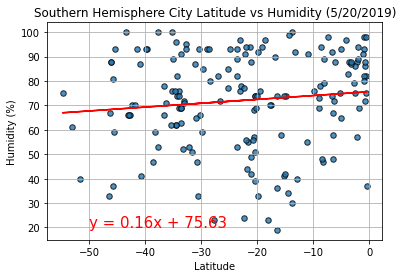

In [35]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_S_hemi["Lat"],df_wx_data_clean_S_hemi["Humidity"])

# Plot the data
df_wx_data_clean_S_hemi.plot(
    "Lat","Humidity",
    title=f"Southern Hemisphere City Latitude vs Humidity ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_S_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(-50,20),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

plt.savefig("output_data/south_lat_humidity.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Humidity as Latitude increases from the South Pole. There is a slightly positive slope in the linear regression that indicates it gets more humid the further north one travels.  However, the r-value indicates that the regression model describes the observed data poorly. This can be seen in the wide spread of the data around the regression line.

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.007627485925231676


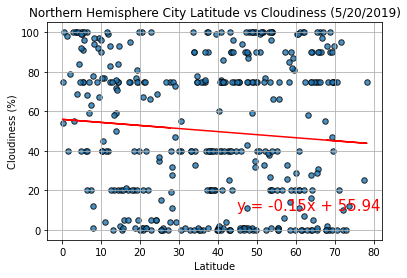

In [36]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_N_hemi["Lat"],df_wx_data_clean_N_hemi["Cloudiness"])

# Plot the data
df_wx_data_clean_N_hemi.plot(
    "Lat","Cloudiness",
    title=f"Northern Hemisphere City Latitude vs Cloudiness ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_N_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(45,10),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

plt.savefig("output_data/north_lat_cloudiness.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Cloudiness as Latitude increases from the Equator. There is a slightly negative slope in the linear regression that indicates it gets less cloudy the further north one travels.  However, the r-value indicates that the regression model describes the observed data poorly. This can be seen in the wide spread of the data around the regression line.

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.052945302059843505


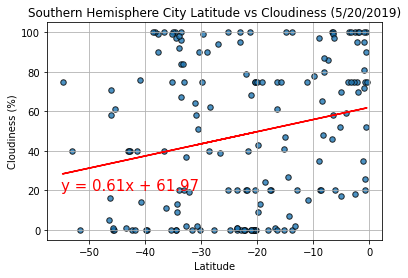

In [38]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_S_hemi["Lat"],df_wx_data_clean_S_hemi["Cloudiness"])

# Plot the data
df_wx_data_clean_S_hemi.plot(
    "Lat","Cloudiness",
    title=f"Southern Hemisphere City Latitude vs Cloudiness ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_S_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(-55,20),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

plt.savefig("output_data/south_lat_cloudiness.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Cloudiness as Latitude increases from the South Pole. There is a positive slope in the linear regression that indicates it gets more cloudy the further north one travels.  However, the r-value indicates that the regression model describes the observed data poorly. This can be seen in the wide spread of the data around the regression line.

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.01147861049256357


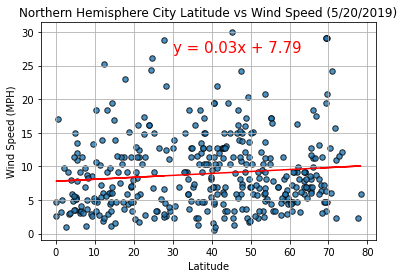

In [40]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_N_hemi["Lat"],df_wx_data_clean_N_hemi["Wind Speed"])

# Plot the data
df_wx_data_clean_N_hemi.plot(
    "Lat","Wind Speed",
    title=f"Northern Hemisphere City Latitude vs Wind Speed ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_N_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(30,27),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Wind Speed (MPH)")

plt.savefig("output_data/north_lat_wndspd.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Wind Speed as Latitude increases from the Equator. The slope is negligible in the linear regression indicating that wind speed is not related to latitude in the Northern Hemisphere. The r-value agrees that the regression model describes the observed data poorly. This can also be seen in the wide spread of the data around the regression line.

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.11293389416296573


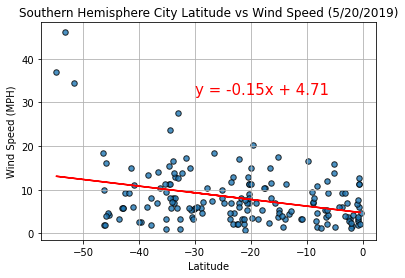

In [42]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_clean_S_hemi["Lat"],df_wx_data_clean_S_hemi["Wind Speed"])

# Plot the data
df_wx_data_clean_S_hemi.plot(
    "Lat","Wind Speed",
    title=f"Southern Hemisphere City Latitude vs Wind Speed ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_clean_S_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(-30,32),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Wind Speed (MPH)")

plt.savefig("output_data/south_lat_wndspd.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Wind spead as Latitude increases from the South Pole. There is a slightly negative slope in the linear regression that indicates it gets less windy the further north one travels.  However, the r-value indicates that the regression model describes the observed data poorly. This can be seen in the wide spread of the data around the regression line.